# MOFA-FLEX Maps Spatial Gene Program Activity in Breast Cancer

Spatial transcriptomics provides a unique view of how gene expression varies across the architecture of complex tissues such as tumors.
However, current technologies often capture only a limited number of genes, making it challenging to uncover transcriptome-wide programs and their spatial organization.

To address this, we apply MOFA-FLEX to jointly analyze matched breast cancer datasets generated from two adjacent FFPE tissue sections:
one profiled with 10x Chromium single-cell RNA-seq for broad transcriptomic coverage, and another with 10x Xenium spatial transcriptomics for targeted spatial profiling.
By leveraging the complementary strengths of both assays, MOFA-FLEX integrates non-spatial and spatial data to infer biologically meaningful, spatially resolved gene programs that characterize the tumor microenvironment.

In [1]:
import os
import sys
# Do not show FutureWarnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import mofaflex as mfl

/home/aqoku/miniforge3/envs/mfl_exp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



Using matplotlib backend: module://matplotlib_inline.backend_inline


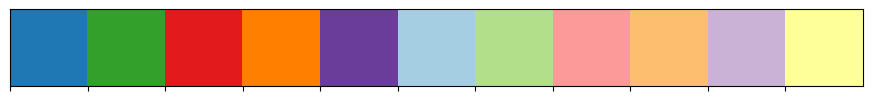

In [2]:
%matplotlib
%matplotlib inline
import plotnine as p9
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import matplotlib as mpl
from functools import partial
from mizani.palettes import brewer_pal


CONSTANT_SIZE = 12

mpl.rcParams["svg.fonttype"] = "none"
mpl.rcParams["font.family"] = "Helvetica"
mpl.rcParams["font.size"] = CONSTANT_SIZE
mpl.rcParams["axes.labelsize"] = CONSTANT_SIZE
mpl.rcParams["axes.titlesize"] = CONSTANT_SIZE
mpl.rcParams["xtick.labelsize"] = CONSTANT_SIZE
mpl.rcParams["ytick.labelsize"] = CONSTANT_SIZE
mpl.rcParams["legend.fontsize"] = CONSTANT_SIZE
mpl.rcParams["figure.titlesize"] = CONSTANT_SIZE

p9.options.base_family = "Helvetica"
th = p9.theme_bw(base_size=CONSTANT_SIZE, base_family="Helvetica") + p9.theme(
    line=p9.element_line(size=0.5),
    rect=p9.element_rect(size=0.5),
    panel_grid_minor=p9.element_blank(),
    panel_border=p9.element_line(),
    axis_ticks=p9.element_line(color="black"),
    axis_ticks_minor=p9.element_blank(),
    axis_text=p9.element_text(color="black", size=CONSTANT_SIZE),
    strip_background=p9.element_blank(),
    strip_text=p9.element_text(color="black", size=CONSTANT_SIZE),
    legend_text=p9.element_text(size=CONSTANT_SIZE),
    legend_key=p9.element_blank(),
    plot_title=p9.element_text(ha="center"),
    # aspect_ratio=1,
)
p9.theme_set(th)


DISCRETE_COLORS = [
    "#1f78b4",
    "#33a02c",
    "#e31a1c",
    "#ff7f00",
    "#6a3d9a",
    "#a6cee3",
    "#b2df8a",
    "#fb9a99",
    "#fdbf6f",
    "#cab2d6",
    "#ffff99",
]

GREY_COLOR = "#d3d3d3"

discrete_scale_fill = p9.scale_fill_manual(values=DISCRETE_COLORS)
discrete_scale_color = p9.scale_color_manual(values=DISCRETE_COLORS)

sns.palplot(DISCRETE_COLORS)

In [3]:
device = f"cuda:{mfl.tl.get_free_gpu_idx()}"
device

'cuda:0'

## Load and Pre-process Data

We jointly analyze two complementary breast cancer datasets generated from adjacent FFPE tissue sections:

- Chromium scRNA-seq providing broad transcriptomic coverage across thousands of genes, and
- Xenium spatial transcriptomics capturing the spatial organization of a targeted gene panel at near single-cell resolution.

We load both datasets into separate MOFA-FLEX groups, remove low-quality spatial barcodes based on prior filtering, and retain the top 3,000 most variable genes from the Chromium dataset to define the shared feature space. All gene identifiers are standardized to uppercase symbols to ensure consistent alignment across modalities.

In [4]:
data = {
    "group_xenium": {"rna": sc.read_h5ad("data/xenium.h5ad")},
    "group_chromium": {"rna": sc.read_h5ad("data/chromium.h5ad")},
}
remove_idx = pd.read_csv("data/remove_idx.csv", index_col=0)["0"].astype(str).tolist()
keep_idx = pd.Index(
    [on for on in data["group_xenium"]["rna"].obs_names if on not in remove_idx]
)
data["group_xenium"]["rna"] = data["group_xenium"]["rna"][keep_idx, :].copy()
feature_vars = data["group_chromium"]["rna"].to_df().var()

data["group_chromium"]["rna"] = data["group_chromium"]["rna"][
    :, feature_vars.sort_values(ascending=False).iloc[:3000].index
].copy()
data["group_chromium"]["rna"].var_names = (
    data["group_chromium"]["rna"].var["symbol"].astype(str).str.upper()
)
data["group_xenium"]["rna"].var_names = (
    data["group_xenium"]["rna"].var["symbol"].astype(str).str.upper()
)
data

{'group_xenium': {'rna': AnnData object with n_obs × n_vars = 166283 × 313
      obs: 'celltype', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
      var: 'symbol'
      uns: 'log1p'
      obsm: 'spatial'
      layers: 'counts'},
 'group_chromium': {'rna': AnnData object with n_obs × n_vars = 30365 × 3000
      obs: 'celltype'
      var: 'symbol'
      uns: 'log1p'
      layers: 'counts'}}

## Load and Filter Gene Set Annotations (Gene Programs)

To guide the interpretation of latent factors, we incorporate prior biological knowledge from the MSigDB Hallmark collection.
Each gene set is converted to uppercase for compatibility with the dataset identifiers and filtered to retain only those with sufficient coverage within the Chromium scRNA-seq dataset (present in at least 20% of features and containing 25–300 genes).
These curated gene programs serve as interpretable annotations that link inferred latent factors to established biological pathways.

In [5]:
def to_upper(feature_set_collection):
    return mfl.FeatureSets(
        [
            mfl.FeatureSet([f.upper() for f in fs], fs.name)
            for fs in feature_set_collection
        ],
        name=feature_set_collection.name,
    )


hallmark_collection = mfl.FeatureSets.from_gmt(
    "../msigdb/h.all.v7.5.1.symbols.gmt", name="hallmark"
)

gene_set_collection = hallmark_collection
gene_set_collection = to_upper(gene_set_collection)

gene_set_collection = gene_set_collection.filter(
    data["group_chromium"]["rna"].var_names,
    min_fraction=0.2,
    min_count=25,
    max_count=300,
    # keep=keep,
)

In [6]:
import re

def _prettify_name(
    name: str,
    mapper: dict[str, str] = None,
    abbreviation_length: int = 40,
    end_with_database: bool = True,
) -> str:
    if not isinstance(name, str):
        raise TypeError("`factor` must be a string.")
    if not isinstance(abbreviation_length, int) or abbreviation_length <= 0:
        raise ValueError("`abbreviation_length` must be a positive integer.")

    # Replace underscores with spaces
    name = name.replace("_", " ")

    # Replace using dictionary
    if mapper is not None:
        for key, value in mapper.items():
            name = name.replace(key, value)

    # Abbreviate if needed
    if len(name) > abbreviation_length:
        name = name[:abbreviation_length] + "…"

    # Move [X] from beginning to end, e.g. "[DB] Name" → "Name [DB]"
    if end_with_database:
        match = re.match(r"^(\[.*\]) (.*)", name)
        if match:
            name = f"{match.group(2)} {match.group(1)}"

    # Title case
    return name.title()


for gs in gene_set_collection:
    gs.name = _prettify_name(gs.name, mapper={"HALLMARK": "[H]", "HAN": "[M]"})

sorted([(len(gs), gs.name) for gs in gene_set_collection])[:10]

[(33, 'Dna Repair [H]'),
 (39, 'Pi3K Akt Mtor Signaling [H]'),
 (40, 'Interferon Alpha Response [H]'),
 (40, 'Uv Response Up [H]'),
 (41, 'Coagulation [H]'),
 (41, 'Protein Secretion [H]'),
 (43, 'Inflammatory Response [H]'),
 (44, 'Androgen Response [H]'),
 (44, 'Heme Metabolism [H]'),
 (45, 'E2F Targets [H]')]

In [7]:
data["group_chromium"]["rna"].varm["gene_set_mask"] = gene_set_collection.to_mask(
    data["group_chromium"]["rna"].var_names.tolist()
).T

## Model Configuration and Training

We next train a spatially informed MOFA-FLEX model to jointly learn latent factors across the matched Xenium spatial and Chromium scRNA-seq datasets.
The model integrates both groups under a shared latent representation, with Gaussian process priors applied to the spatial (Xenium) group to capture smooth spatial variation. Hallmark gene programs are provided as annotations to constrain the factor loadings toward biologically meaningful pathways. A Horseshoe prior encourages sparsity in the weights, while nonnegative constraints on factors and weights ensure interpretable, additive signal contributions. Training is performed on GPU with 10,000-cell batches for up to 200 epochs using an RBF kernel for spatial smoothing.

In [8]:
data_opts = mfl.DataOptions(
    group_by=None,
    scale_per_group=True,
    annotations_varm_key={"rna": "gene_set_mask"},
    covariates_obs_key=None,
    covariates_obsm_key={
        "group_xenium": "spatial",
        "group_chromium": None,
    },
    use_obs="union",
    use_var="union",
    plot_data_overview=False,
)

model_opts = mfl.ModelOptions(
    n_factors=3,
    weight_prior="Horseshoe",
    factor_prior={"group_xenium": "GP", "group_chromium": "Normal"},
    likelihoods="Normal",
    nonnegative_weights=True,
    nonnegative_factors=True,
    annotation_confidence=0.999,
    init_factors=0.0,
    init_scale=0.1,
)

training_opts = mfl.TrainingOptions(
    device=device,
    batch_size=10000,
    max_epochs=200,
    n_particles=1,
    lr=0.003,
    seed=2511021635,
)

smooth_opts = mfl.SmoothOptions(
    n_inducing=100,
    kernel="RBF",
    warp_groups=[],
    warp_interval=20,
    warp_open_begin=True,
    warp_open_end=True,
    warp_reference_group=None,
)

model = mfl.MOFAFLEX(
    data, data_opts, model_opts, training_opts, smooth_opts
)

WARNING	Could not import dask. Data arrays may be copied, resulting in high memory usage.
/home/aqoku/miniforge3/envs/mfl_exp/lib/python3.12/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
/home/aqoku/miniforge3/envs/mfl_exp/lib/python3.12/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
INFO	Initializing factors using `0.0` method...
  0%|                                                                                                                              | 0/200 [00:00<?, ?epochs/s]/home/aqoku/miniforge3/envs/mfl_exp/lib/python3.12/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tens

/home/aqoku/miniforge3/envs/mfl_exp/lib/python3.12/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



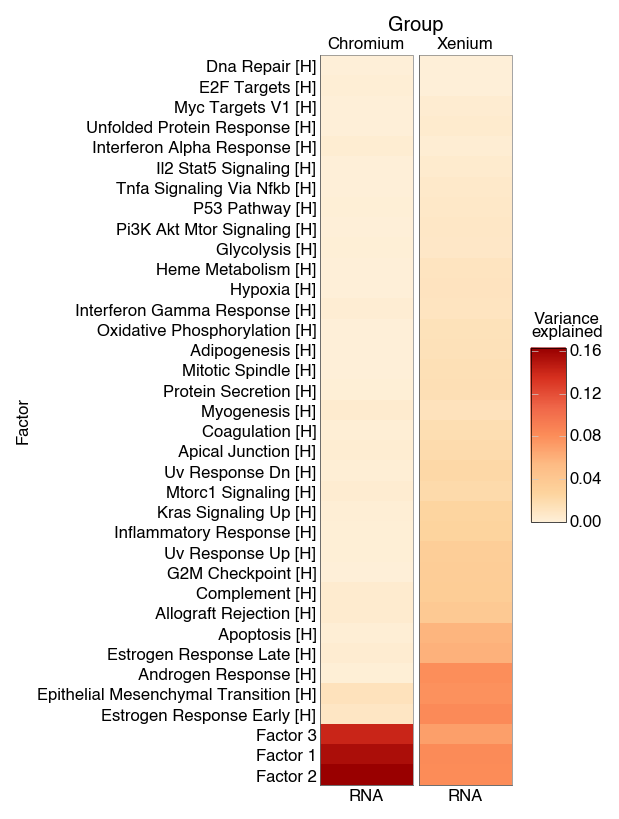

In [9]:
p = mfl.pl.variance_explained(model, figsize=(6, 8))
p = (
    p
    + p9.theme(axis_text_x=p9.element_text(angle=0))
    + p9.scale_x_discrete(labels={"rna": "RNA"})
    + p9.labs(title="Group", y="Factor", x="")
    + p9.facet_wrap(
        "group",
        labeller=lambda l: {"group_chromium": "Chromium", "group_xenium": "Xenium"}[l],
    )
)

p.show()

In [10]:
xenium_celltype_colors = (
    [
        DISCRETE_COLORS[3],
        DISCRETE_COLORS[1],
        DISCRETE_COLORS[0],
        DISCRETE_COLORS[4],
        DISCRETE_COLORS[5],
        DISCRETE_COLORS[2],
    ]
    + DISCRETE_COLORS[6:]
    + DISCRETE_COLORS[:3]
)

In [11]:
factor_adata = model.get_factors("anndata")["group_xenium"]
# prettify cell type names
celltype_map = {
    "DCIS_2": "DCIS 2",
    "Macrophages_1": "Macrophages",
    "Invasive_Tumor": "Invasive Tumor",
    "Stromal": "Stromal",
    "CD4+_T_Cells": "T Cells",
    "Unlabeled": "UNL",
    "CD8+_T_Cells": "T Cells",
    "Prolif_Invasive_Tumor": "Invasive Tumor",
    "Endothelial": "Endothelial",
    "Macrophages_2": "Macrophages",
    "T_Cell_&_Tumor_Hybrid": "T Cells & Tumor",
    "Myoepi_ACTA2+": "Myoepithelial",
    "B_Cells": "B Cells",
    "LAMP3+_DCs": "Dendritic Cells",
    "DCIS_1": "DCIS 1",
    "Perivascular-Like": "Perivascular Like",
    "Stromal_&_T_Cell_Hybrid": "Stromal & T Cells",
    "Myoepi_KRT15+": "Myoepithelial",
    "IRF7+_DCs": "Dendritic Cells",
    "Mast_Cells": "Mast Cells",
}

factor_adata.obs["Celltype"] = (
    factor_adata.obs["celltype"].map(celltype_map).fillna(factor_adata.obs["celltype"])
).astype("category")


In [12]:
sc.pp.neighbors(factor_adata, n_neighbors=15, use_rep="X")
sc.tl.umap(factor_adata, min_dist=0.4)

/home/aqoku/miniforge3/envs/mfl_exp/lib/python3.12/site-packages/plotnine/scales/scale_manual.py:45: PlotnineWarning: The palette of scale_fill_manual can return a maximum of 14 values. 15 were requested from it.
/home/aqoku/miniforge3/envs/mfl_exp/lib/python3.12/site-packages/plotnine/scales/scale_manual.py:45: PlotnineWarning: The palette of scale_fill_manual can return a maximum of 14 values. 15 were requested from it.


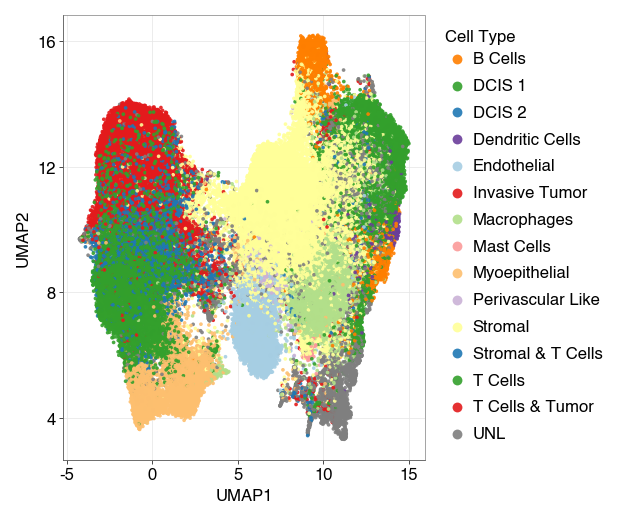

In [13]:
# Prepare data for plotting
umap_df = pd.DataFrame(
    factor_adata.obsm["X_umap"],
    columns=["UMAP1", "UMAP2"],
    index=factor_adata.obs_names,
)
umap_df["Celltype"] = factor_adata.obs["Celltype"]

# Define a categorical palette
categories = factor_adata.obs["Celltype"].cat.categories
palette = p9.scale_fill_manual(
    values={cat: color for cat, color in zip(categories, xenium_celltype_colors[: len(categories)])}
)

# Plot with plotnine
p = (
    p9.ggplot(umap_df, p9.aes(x="UMAP1", y="UMAP2", fill="Celltype"))
    + p9.geom_point(size=1.5, stroke=0, alpha=0.9)
    + p9.theme(figure_size=(6, 5))
    + palette
    + p9.guides(fill=p9.guide_legend(override_aes={"size": 4}))
    + p9.labs(fill="Cell Type")
)
p.show()

In [14]:
def rank(factor_adata, groupby, group_idx, n_factors=3, pl_type="dotplot", **kwargs):
    """
    Rank latent factors by association with sample groups and visualise as a Scanpy plot.
    Useful for factor activity summaries (e.g. dotplots).

    Parameters
    ----------
    factor_adata : AnnData
        Latent space.
    groupby : str
        Column in obs to group by (e.g. cell type or condition).
    group_idx : str
        Group key in model.get_factors("anndata") (e.g. "group_1").
    n_factors : int
        Number of top factors to plot per group.
    pl_type : str
        Type of Scanpy ranking plot: one of
        ["dotplot", "heatmap", "matrixplot", "violin", "stacked_violin"].
    **kwargs
        Additional arguments passed to Scanpy plotting function.
    """

    # Compute ranking of factors across groups
    sc.tl.rank_genes_groups(factor_adata, groupby)

    # Select plotting function
    pl_type = (pl_type or "dotplot").lower()
    type_to_fn = {
        "dotplot": sc.pl.rank_genes_groups_dotplot,
        "heatmap": sc.pl.rank_genes_groups_heatmap,
        "matrixplot": sc.pl.rank_genes_groups_matrixplot,
        "violin": sc.pl.rank_genes_groups_violin,
        "stacked_violin": sc.pl.rank_genes_groups_stacked_violin,
    }
    if pl_type not in type_to_fn:
        raise ValueError(f"Invalid pl_type '{pl_type}'. Choose from {list(type_to_fn.keys())}.")

    # Run plotting function (show by default)
    return type_to_fn[pl_type](factor_adata, n_genes=n_factors, **kwargs)

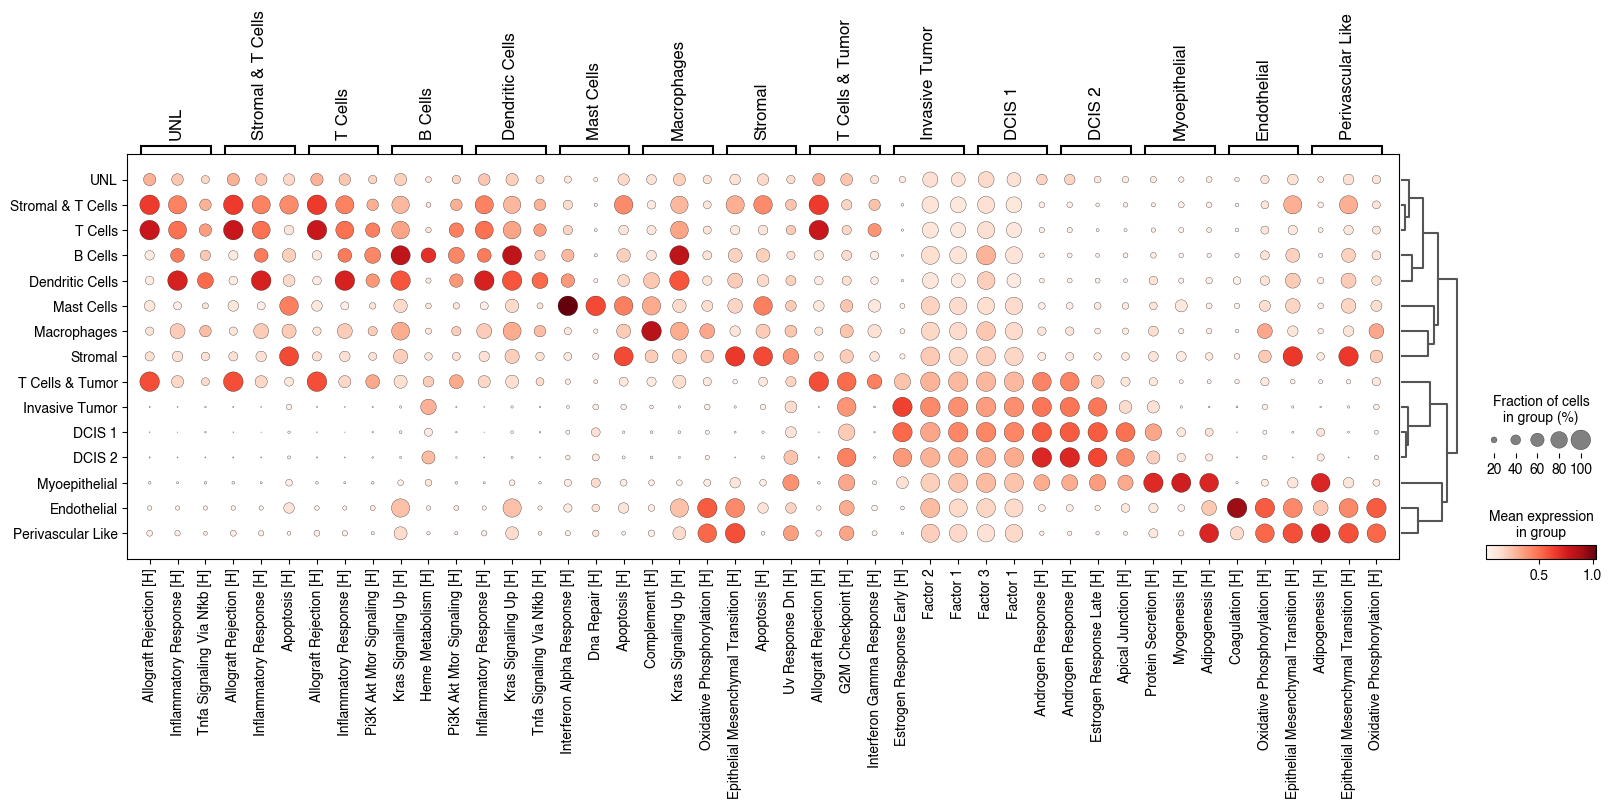

In [15]:
rank(
    factor_adata,
    "Celltype",
    group_idx="group_xenium",
    n_factors=3,
    pl_type="dotplot",
)

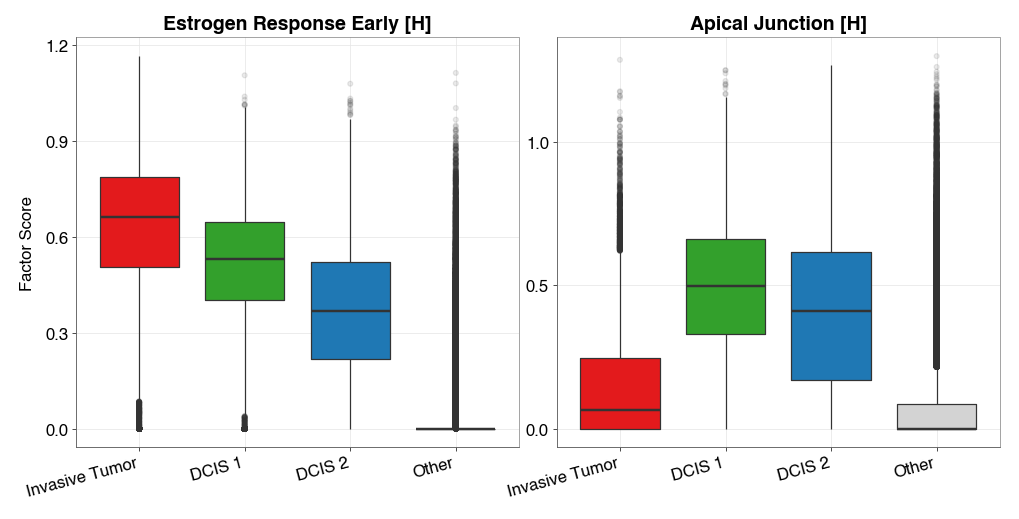

In [16]:
selected_factors = ["Estrogen Response Early [H]", "Apical Junction [H]"]

wide = pd.concat(
    [factor_adata.to_df().loc[:, selected_factors],
     factor_adata.obs["Celltype"].rename("Cells")],
    axis=1
)

focus_groups = ["Invasive Tumor", "DCIS 1", "DCIS 2"]
wide["Cells"] = wide["Cells"].astype(str)
wide.loc[~wide["Cells"].isin(focus_groups), "Cells"] = "Other"

df_long = wide.melt(id_vars="Cells", var_name="Factor", value_name="Factor Score").copy()

df_long["Cells"] = pd.Categorical(
    df_long["Cells"],
    categories=focus_groups + ["Other"],
    ordered=True,
)
df_long["Factor"] = pd.Categorical(
    df_long["Factor"],
    categories=selected_factors,
    ordered=True,
)

p = (
    p9.ggplot(df_long, p9.aes(x="Cells", y="Factor Score", fill="Cells"))
    + p9.geom_boxplot(outlier_alpha=0.1)
    + p9.facet_wrap("~Factor", ncol=2, scales="free_y")
    + p9.scale_fill_manual(values=[DISCRETE_COLORS[2], DISCRETE_COLORS[1], DISCRETE_COLORS[0], "#d3d3d3"])
    + p9.theme(
        figure_size=(10, 5),
        axis_title_x=p9.element_blank(),
        axis_text_x=p9.element_text(size=12, rotation=15, ha="right"),
        axis_text_y=p9.element_text(size=12),
        strip_text=p9.element_text(size=14, weight="bold"),
        legend_position="none",
    )
)
p.show()

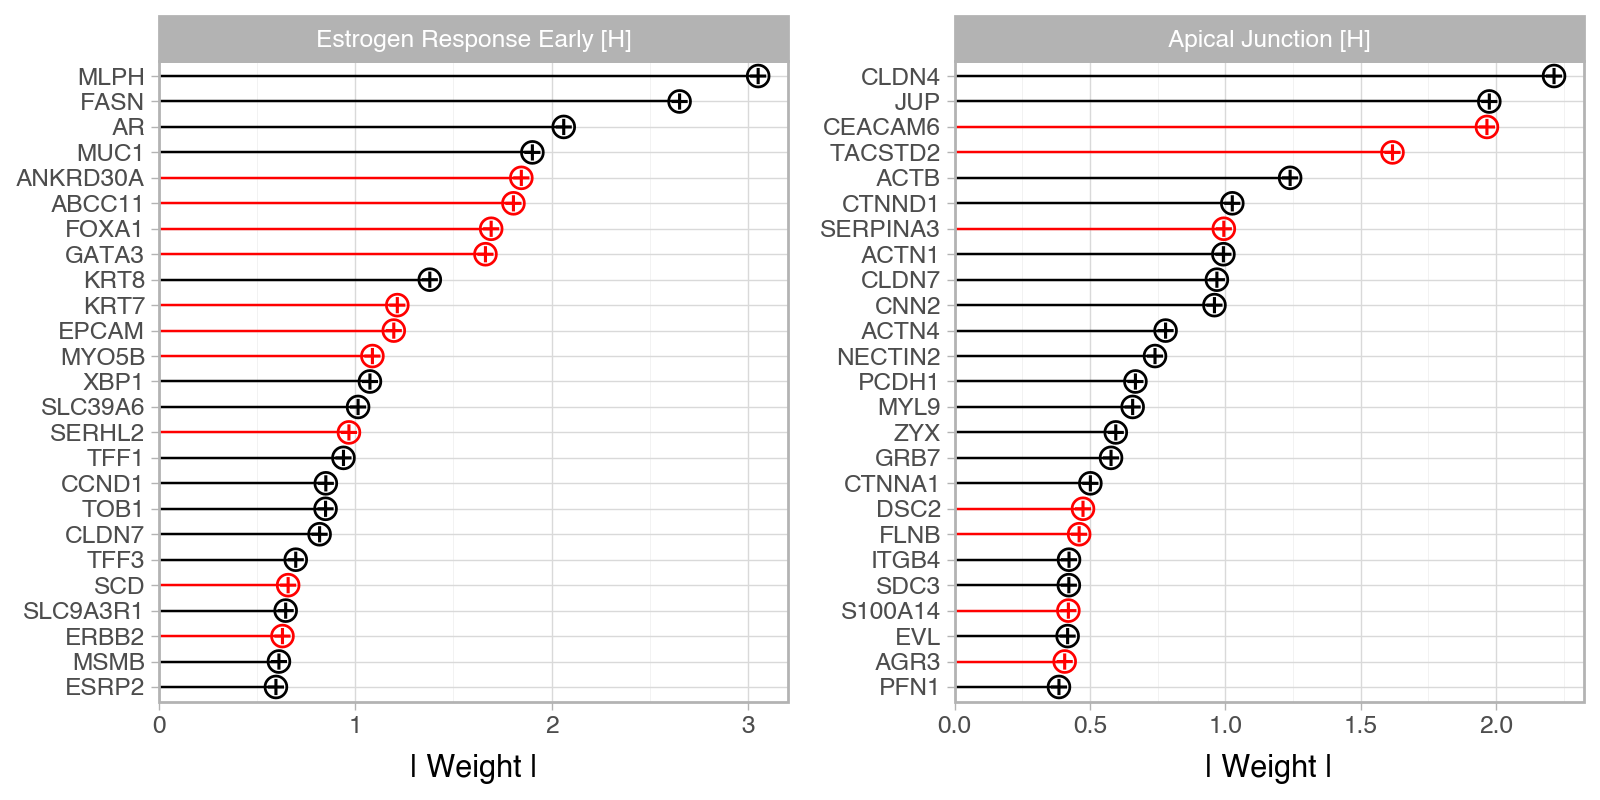

In [17]:
p1 = (
    mfl.pl.top_weights(model, n_features=25, views="rna", factors="Estrogen Response Early [H]")
    + p9.theme_light()
    + p9.theme(figure_size=(8, 4), legend_position="none")
)
# p1.show()
p2 = (
    mfl.pl.top_weights(model, n_features=25, views="rna", factors="Apical Junction [H]")
    + p9.theme_light()
    + p9.theme(figure_size=(8, 4), legend_position="none")
)
# p2.show()
p1 | p2

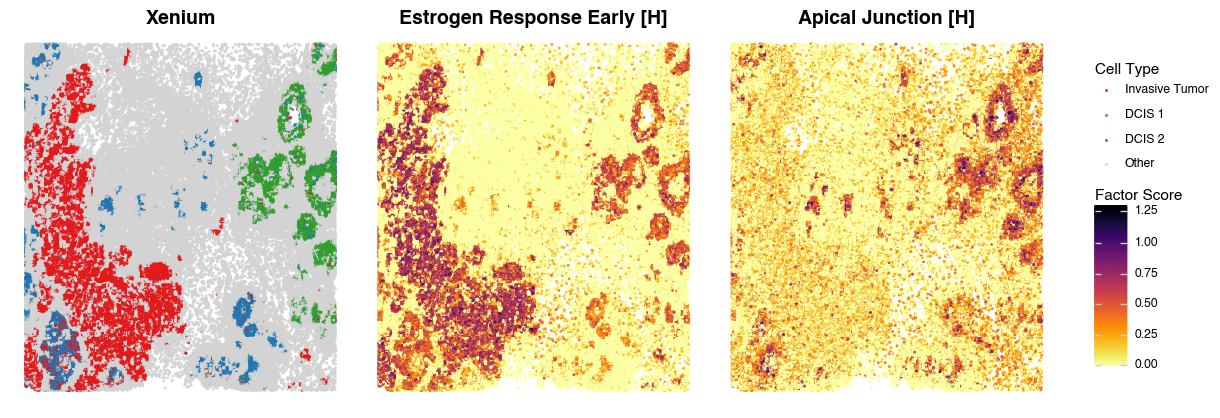

In [18]:
# Prepare the data
z_df = model.get_factors("anndata", ordered=True)["group_xenium"].to_df()
z_df.head()

cov_df = pd.DataFrame(
    model.covariates["group_xenium"],
    index=z_df.index,
)
cov_df.columns = ["x", "y"]
cov_df.head()

celltype_df = factor_adata.obs[["Celltype"]].copy()
celltype_df["Celltype"] = celltype_df["Celltype"].astype(str)
celltype_df.loc[
    ~celltype_df["Celltype"].isin(["DCIS 1", "DCIS 2", "Invasive Tumor"]),
    "Celltype",
] = "Other"
celltype_df = celltype_df.rename(columns={"Celltype": "Xenium"})

# Combine spatial + factor + cell type data
plot_data = pd.concat([z_df, cov_df, celltype_df], axis=1).copy()

# Define order and palette
cat_order = ["Invasive Tumor", "DCIS 1", "DCIS 2", "Other"]
cat_palette = [DISCRETE_COLORS[2], DISCRETE_COLORS[1], DISCRETE_COLORS[0], "#d3d3d3"]

# Melt only continuous factors
df_factors = pd.melt(
    plot_data,
    id_vars=["x", "y"],
    value_vars=["Estrogen Response Early [H]", "Apical Junction [H]"],
    var_name="View",
    value_name="Value"
)
df_factors["Type"] = "Factor"

# Melt categorical (Xenium cell types)
df_cells = plot_data[["x", "y", "Xenium"]].copy()
df_cells = df_cells.rename(columns={"Xenium": "Value"})
df_cells["View"] = "Xenium"
df_cells["Type"] = "Categorical"

# Combine and preserve Xenium first
df_long = pd.concat([df_cells, df_factors], axis=0)
df_long["View"] = pd.Categorical(
    df_long["View"],
    categories=["Xenium", "Estrogen Response Early [H]", "Apical Junction [H]"],
    ordered=True,
)

# Base plot
p = (
    p9.ggplot(df_long, p9.aes("x", "y"))
    + p9.facet_wrap("~View", ncol=3, scales="fixed", labeller="label_value")
    + p9.theme_void()
    + p9.theme(
        figure_size=(12, 4),
        strip_text=p9.element_text(size=14, weight="bold"),
        legend_position="right",
    )
)

# Add Xenium (categorical)
p = p + p9.geom_point(
    data=df_long[df_long["Type"] == "Categorical"],
    mapping=p9.aes(fill="Value"),
    size=1.2, stroke=0, alpha=0.9
) + p9.scale_fill_manual(
    name="Cell Type",
    values=cat_palette,
    limits=cat_order
)

df_long_float = df_long.loc[df_long["Type"] == "Factor", :].copy()
df_long_float["Value"] = df_long_float["Value"].astype(np.float32)
# Add factors (continuous)
p = p + p9.geom_point(
    data=df_long_float,
    mapping=p9.aes(color="Value"),
    size=1.2, stroke=0, alpha=0.9
) + p9.scale_color_cmap(name="Factor Score", cmap_name="inferno_r")

p.show()